In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class Rectangle:
    def __init__(self, h, w, v):
        self.h = h
        self.w = w
        self.v = v
        
    def how_many_fit(self, height):
        return height // self.h
    
    def row_value(self, height):
        return self.how_many_fit(height) * self.v
    
class Circle:
    
    def __init__(self, radius, possible_rectangles, rectangles=None):
        self.radius = radius
        self.possible_rectangles = possible_rectangles
        if rectangles is None:
            self.rectangles = self.initialize_rectangles()
        else:
            self.rectangles = rectangles
        
    def initialize_rectangles(self):
        widths = 0
        list_rectangles = []
        while widths <= 2 * self.radius:
            random_rectangle = self.possible_rectangles[random.randint(0, len(self.possible_rectangles) - 1)]
            list_rectangles.append(random_rectangle)
            widths += random_rectangle.w
        return list_rectangles
        
    def get_value(self):
        rectangle = self.rectangles[0]
        index = 0
        # x = R - 0.5 * np.sqrt(4 * np.square(R) - np.square(h))
        x_left = self.radius - 0.5 * np.sqrt(4 * np.square(self.radius) - np.square(rectangle.h))
        x_right = x_left + rectangle.w
        left = rectangle.h
        right = 2 * np.sqrt(x_right * (2 * self.radius - x_right))
        value = 0
        while x_right < 2 * self.radius:
            # print(left, right, x_left, x_right, rectangle.row_value(min(left, right)))
            value += rectangle.row_value(min(left, right))
            index += 1
            if index >= len(self.rectangles):
                break
            rectangle = self.rectangles[index]
            x_left = x_right
            x_right = x_left + rectangle.w
            left = right
            if x_right < 2 * self.radius:
                right = 2 * np.sqrt(x_right * (2 * self.radius - x_right))
        return value
    
    def cross(self, circle):
        n = random.randint(0, 2 * self.radius)
        child = []
        widths = 0
        for rectangle in circle.rectangles:
            child.append(rectangle)
            widths += rectangle.w
            if widths > n:
                break
        widths = 0
        for rectangle in self.rectangles:
            widths += rectangle.w
            if widths >= n:
                child.append(rectangle)
            if widths > 2 * self.radius:
                break
        return Circle(self.radius, self.possible_rectangles, child)
        
    def mutate(self):
        index = random.randint(0, len(self.rectangles) - 1)
        self.rectangles[index] = self.possible_rectangles[random.randint(0, len(self.possible_rectangles) - 1)]
        return self
    
    def show(self):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.add_artist(plt.Circle((0, 0), self.radius, color='blue', fill=False, zorder=3))
        
        rectangle = self.rectangles[0]
        index = 0
        x_left = self.radius - 0.5 * np.sqrt(4 * np.square(self.radius) - np.square(rectangle.h))
        x_right = x_left + rectangle.w
        y_left = rectangle.h / 2
        y_right = np.sqrt(x_right * (2 * self.radius - x_right))
        while x_right < 2 * self.radius:
            # print(f"x_left: {x_left}, x_right: {x_right}, y_left: {y_left}, y_right: {y_right}")
            y = min(y_left, y_right)
            how_many_fit = int(rectangle.how_many_fit(2 * y))
            for i in range(how_many_fit):
                ax.add_patch(plt.Rectangle((x_left - self.radius, y - i * rectangle.h), rectangle.w, -rectangle.h, edgecolor='red', facecolor='none', zorder=4))
            index += 1
            rectangle = self.rectangles[index]
            x_left = x_right
            x_right = x_left + rectangle.w
            y_left = y_right
            if x_right < 2 * self.radius:
                y_right = np.sqrt(x_right * (2 * self.radius - x_right))

        ax.set_xlim(-self.radius-50, self.radius+50)
        ax.set_ylim(-self.radius-50, self.radius+50)
        ax.set_aspect('equal', 'box')

        ax.grid(True, zorder=1)
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        

In [4]:
class GeneticAlgorith:
    
    def __init__(self, rectangles, radius, pop_size, generations, crossover_rate = 0.7, mutation_rate = 0.2):
        self.rectangles = rectangles
        self.radius = radius
        self.popSize = pop_size
        self.generations = generations
        self.crossoverRate = crossover_rate
        self.mutationRate = mutation_rate
        self.population = self.initialize_population()
        self.bestSolution = None
        self.bestFitness = 0
            
    def initialize_population(self):
        return [Circle(self.radius, self.rectangles) for _ in range(self.popSize)]
    
    def calculate_fitness(self):
        return [circle.get_value() for circle in self.population]
            
    def tournament_selection(self, fitness, k):  
        return [self.population[np.argmax(np.random.choice(fitness, k))] for _ in range(self.popSize * 2)]

    def roulette_wheel_selection(self, fitness):
        #  probability of choosing an individual for breeding of the next generation is proportional to its fitness
        total_fitness = sum(fitness)
        probabilities = [f / total_fitness for f in fitness]
        cumulative_probabilities = np.cumsum(probabilities)
        parents = []
        for _ in range(self.popSize * 2):
            rand_num = random.random()
            for i, cumulative_probability in enumerate(cumulative_probabilities):
                if rand_num < cumulative_probability:
                    parents.append(self.population[i])
                    break
        return parents
        
    def crossover(self, parents):
        children = []
        for i in range(0, len(parents), 2):
            if random.random() < self.crossoverRate:
                children.append(parents[i].cross(parents[i + 1]))
            else:
                if random.random() < 0.5:
                    children.append(parents[i])
                else:
                    children.append(parents[i + 1])
        return children
        
    
    def mutate(self, children):
        mask = np.random.rand(len(children)) < self.mutationRate
        return [children[i].mutate() if mask[i] else children[i] for i in range(len(children))]
    
    
    def run(self, condition = float('inf'), tourn_sel_k=3):
        
        # 1. initialize population - in constructor
        
        # 2. stop condition
        for _ in tqdm(range(self.generations)):
            if self.bestFitness >= condition:
                break
                
            # 3. calculate fitness
            fitness = self.calculate_fitness()
            if np.max(fitness) > self.bestFitness:
                self.bestFitness = np.max(fitness)
                self.bestSolution = self.population[np.argmax(fitness)]

            # 4. parents selection
            # parents = self.tournament_selection(fitness, tourn_sel_k)
            parents = self.roulette_wheel_selection(fitness)
            
            # 5. crossover
            children = self.crossover(parents)
            
            # 6. mutation
            population = self.mutate(children)
            self.population = population
            
    
    def show_population(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        circle = plt.Circle((0, 0), self.radius, color='blue', fill=False, zorder=3)
        ax.add_artist(circle)
        for rect, (x, y), rotation in self.population:
            height, width, value = rect
            if rotation == 90:
                height, width = width, height
            rect_patch = plt.Rectangle((x, y), width, -height, edgecolor='red', facecolor='none', zorder=4)
            ax.add_patch(rect_patch)
            ax.text(x + width / 2, y - height / 2, str(value), color='black', ha='center', va='center', zorder=4)
        
        ax.set_xlim(-self.radius-50, self.radius+50)
        ax.set_ylim(-self.radius-50, self.radius+50)
        ax.set_aspect('equal', 'box')
        
        ax.grid(True, zorder=1)
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')


### Algorytm genetyczny
**Osobnik** — okrąg napakowany prostokątami (okrąg jest podzielony na paski (pionowe) o szerokości kolejnych prostokątów, w każdym znajduje się maksymalna liczba prostokątów, które się mieszczą w okręgu)
**Populacja** — zbiór okręgów napakowanych prostokątami
**Genotyp** — lista prostokątów
**Gen** — pojedynczy prostokąt z listy

**Krzyżowanie** — losujemy liczbę n z przedziału (0, 2R), a następnie dziecku dopisujemy geny rodzica1 aż suma szerokości prostokątów nie przekroczy n, a potem to samo robimy dla rodzica2 z tą różnicą, że dopiero gdy osiągniemy sumę szerokości równą n to zaczynamy dopisywać geny rodzica2 (w ten sposób otrzymujemy sumę szerokości prostokątów dziecka większą od 2R)
**Mutacja** — losowy wybór prostokąta (genu) z listy (genotypu) i zamiana go na inny wylosowany prostokąt

**Funkcja przystosowania** — suma iloczynu wartości prostokątów (mieszczących się w okręgu) z listy i ich ilości w danym pasku

In [6]:
r800 = pd.read_csv('AE\\r800.csv', header=None)
r800.columns = ['height', 'width', 'value']
r800_arr = [Rectangle(row['height'], row['width'], row['value']) for index, row in r800.iterrows()]

r850 = pd.read_csv('AE\\r850.csv', header=None)
r850.columns = ['height', 'width', 'value']
r850_arr = [Rectangle(row['height'], row['width'], row['value']) for index, row in r850.iterrows()]

r1000 = pd.read_csv('AE\\r1000.csv', header=None)
r1000.columns = ['height', 'width', 'value']
r1000_arr = [Rectangle(row['height'], row['width'], row['value']) for index, row in r1000.iterrows()]

r1100 = pd.read_csv('AE\\r1100.csv', header=None)
r1100.columns = ['height', 'width', 'value']
r1100_arr = [Rectangle(row['height'], row['width'], row['value']) for index, row in r1100.iterrows()]

r1200 = pd.read_csv('AE\\r1200.csv', header=None)
r1200.columns = ['height', 'width', 'value']
r1200_arr = [Rectangle(row['height'], row['width'], row['value']) for index, row in r1200.iterrows()]

 72%|███████▏  | 217/300 [00:03<00:01, 61.97it/s]


30400.0


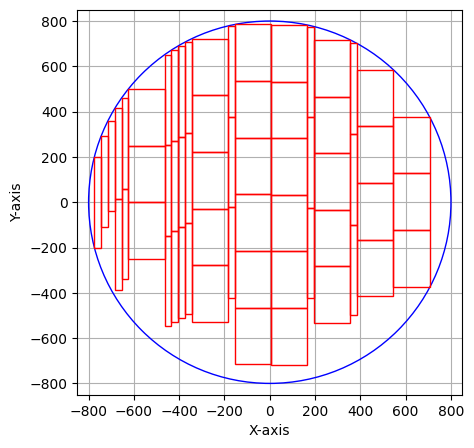

In [6]:
ga = GeneticAlgorith(rectangles=r800_arr, radius=800, pop_size=200, generations=300)
ga.run(condition=30000)
print(ga.bestFitness)
ga.bestSolution.show()

100%|██████████| 100/100 [00:02<00:00, 40.49it/s]


467430.0


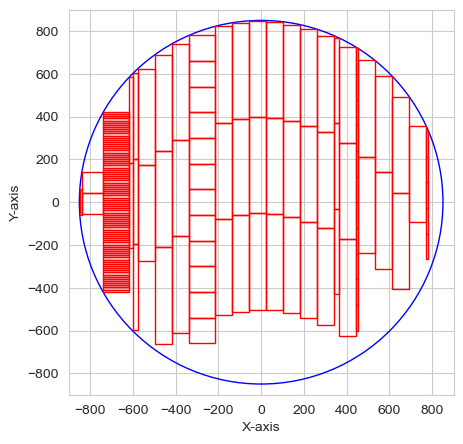

In [7]:
ga = GeneticAlgorith(rectangles=r850_arr, radius=850, pop_size=100, generations=100)
ga.run()
print(ga.bestFitness)
ga.bestSolution.show()

100%|██████████| 10/10 [00:00<00:00, 568.27it/s]


28340.0


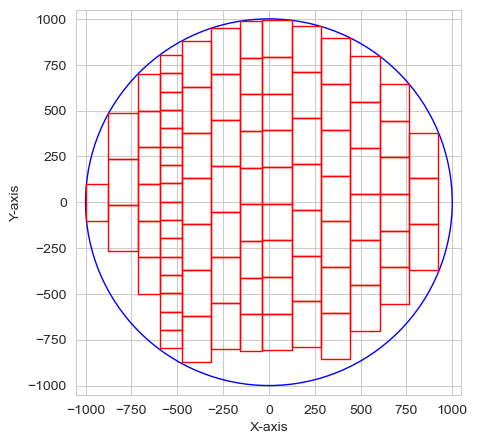

In [8]:
ga = GeneticAlgorith(rectangles=r1000_arr, radius=1000, pop_size=10, generations=10)
ga.run()
# ga.run(condition=17500)
print(ga.bestFitness)
ga.bestSolution.show()

100%|██████████| 10/10 [00:00<00:00, 999.62it/s]


31460.0


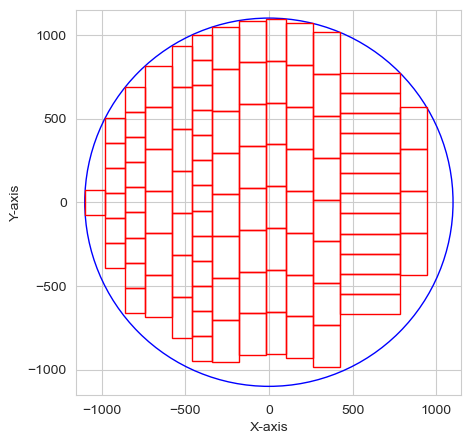

In [10]:
ga = GeneticAlgorith(rectangles=r1100_arr, radius=1100, pop_size=10, generations=10)
ga.run()
# ga.run(condition=25000)
print(ga.bestFitness)
ga.bestSolution.show()

100%|██████████| 100/100 [00:02<00:00, 49.98it/s]


48700.0


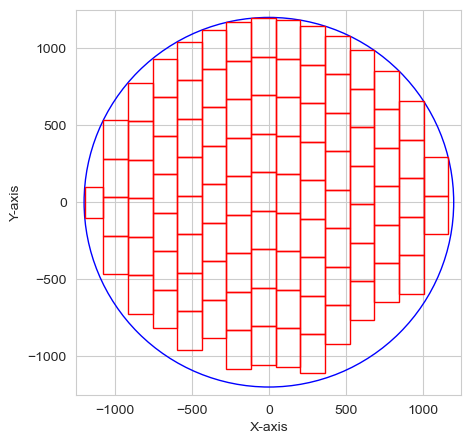

In [11]:
ga = GeneticAlgorith(rectangles=r1200_arr, radius=1200, pop_size=100, generations=100)
ga.run()
# ga.run(condition=30000)
print(ga.bestFitness)
ga.bestSolution.show()